In [1]:
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

h.load_file("stdrun.hoc")
def det_impedance(pos, sec, v0, freqs, dur, extend_impedance: bool):
    imps = []
    for f in freqs:
        h.finitialize(v0)
        h.continuerun(dur)
        imp = h.Impedance()
        imp.loc(pos, sec=sec)
        imp.compute(f, extend_impedance)
        ii = imp.input(pos, sec=sec)
        imps.append(float(ii))
    return imps

def _calc_imp(cell, sections=None, freqs=[0, 1, 10, 100], durinit=100, v0=-70, extend_impedance=False):
    # by default included
    all_imps = {}
    idx = -1
    if sections is None:
        sections = cell.allsec
    for sec in sections:
        print(f"{cell.allsec.index(sec)}/{len(sections)}", end='\r')
        for seg in sec:

            imps = det_impedance(
                seg.x, sec, v0, freqs, durinit, extend_impedance=extend_impedance)
            for imp, f in zip(imps, freqs):
                idx += 1
                all_imps[idx] = {'imp': imp, 'f': f, 'v0': v0,
                                 'durinit': durinit, 'seg': str(seg).split('.', 2)[-1]}

    imp_df = pd.DataFrame.from_dict(all_imps, orient='index')
    imp_df = imp_df.reset_index(drop=True)
    return imp_df

def lambda_f(freq, sec):
    if (sec.n3d() < 2):
        return 1e5*np.sqrt(sec.diam/(4*np.pi*freq*sec.Ra*sec.cm))

    #above was too inaccurate with large variation in 3d diameter
    #so now we use all 3-d points to get a better approximate lambda
    x1 = sec.arc3d(0)
    d1 = sec.diam3d(0)
    lam = 0
    for i in range(sec.n3d()-1):
        i += 1
        x2 = sec.arc3d(i)
        d2 = sec.diam3d(i)
        lam += (x2 - x1)/np.sqrt(d1 + d2)
        x1 = x2
        d1 = d2
        #length of the section in units of lambda
    lam *= np.sqrt(2) * 1e-5*np.sqrt(4*np.pi*freq*sec.Ra*sec.cm)
    return sec.L/lam
class NeuronTemplate:
    def __init__ (self,ID=0,ty=0,col=0, sectionNames = ['soma','dend1','dend2','dend3'], nseg=None):
        self.ID=ID
        self.ty=ty
        self.col=col
        self.sectionNames = sectionNames
        self.createSections()
        self.linearConnection()
        try:
            self.dend1.L = 100
            self.dend1.diam = 1
            self.dend2.L = 100
            self.dend2.diam = 4
            self.dend3.L = 10
            self.dend3.diam = 1
        except Exception as e:
            print(e)
        self.geom_nseg(nseg)
        self.biophys()


    def createSections(self):
        self.allsec = []
        for i in self.sectionNames:
            if '[' in i:
                intm = i.split('[')
                setattr(self,intm[0],[])
                nr = int(intm[1][:-1])
                for inr in range(nr):
                    name = '%s[%i]'%(intm[0],inr)
                    setattr(self,name,h.Section(name=name,cell=self))
                    getattr(self,intm[0]).append(getattr(self,name))
                    self.allsec.append(getattr(self,name))
            else:
                setattr(self,i,h.Section(name=i,cell=self))
                self.allsec.append(getattr(self,i))


    def geom_nseg(self,nseg):

        def mylabda_f(sec,freq = 100):
            nseg = int((sec.L/(0.1*lambda_f(freq,sec))+.9)/2)*2 + 1
            return nseg
        for sec in self.allsec:
            if nseg is None:
                sec.nseg = mylabda_f(sec)
            else:
                sec.nseg = nseg
            #print(f'lambdaf: {mylabda_f(sec)}, TK:{sec.nseg}')


    def biophys(self):
        #order: df or fd  with d: distr and f: fixed. Last called function can overwrite previous values

        #insert channels
        for sec in self.allsec:
            sec.insert('hh')



    def linearConnection(self):
        allsec = list(self.allsec)
        for sec1,sec2 in zip(allsec[:-1],allsec[1:]):
            sec1.connect(sec2(1),0)

cell0 = NeuronTemplate()
cell1 = NeuronTemplate(nseg=1)
cell11 = NeuronTemplate(nseg = 11)
cell31 = NeuronTemplate(nseg = 31)
for sec in h.allsec():
    sec.L=sec.L
    sec.Ra = 0.000001
h.define_shape()

1.0

In [2]:


imp_df_cell1 = _calc_imp(cell1,freqs=[0],extend_impedance=False)
imp_df_cell11 = _calc_imp(cell11,freqs=[0],extend_impedance=False)
imp_df_cell31 = _calc_imp(cell31,freqs=[0],extend_impedance=False)
imp_df_cell0 = _calc_imp(cell0,freqs=[0],extend_impedance=False)

In [3]:
imp_df_cell0

,imp,f,v0,durinit,seg
0,0.927816,0,-70,100,soma(0.5)
1,0.927817,0,-70,100,dend1(0.166667)
2,0.927816,0,-70,100,dend1(0.5)
3,0.927816,0,-70,100,dend1(0.833333)
4,0.927817,0,-70,100,dend2(0.5)
5,0.927817,0,-70,100,dend3(0.5)


In [4]:
imp_df_cell1

,imp,f,v0,durinit,seg
0,0.927847,0,-70,100,soma(0.5)
1,0.927847,0,-70,100,dend1(0.5)
2,0.927848,0,-70,100,dend2(0.5)
3,0.927848,0,-70,100,dend3(0.5)


In [5]:
imp_df_cell11

,imp,f,v0,durinit,seg
0,0.929113,0,-70,100,soma(0.0454545)
1,0.929113,0,-70,100,soma(0.136364)
2,0.929113,0,-70,100,soma(0.227273)
3,0.929113,0,-70,100,soma(0.318182)
4,0.929113,0,-70,100,soma(0.409091)
5,0.929113,0,-70,100,soma(0.5)
6,0.929113,0,-70,100,soma(0.590909)
7,0.929113,0,-70,100,soma(0.681818)
8,0.929113,0,-70,100,soma(0.772727)
9,0.929113,0,-70,100,soma(0.863636)


In [6]:
imp_df_cell0['cell'] = 'cell0'
imp_df_cell1['cell'] = 'cell1'
imp_df_cell11['cell'] = 'cell11'
imp_df_cell31['cell'] = 'cell31'
imp_df = pd.concat([imp_df_cell0,imp_df_cell1,imp_df_cell11,imp_df_cell31]).reset_index(drop=True)


In [7]:
def getarea(seg,cell):
    seg = seg.split('(')
    loc = float(seg[-1][:-1])
    seg = seg[0]
    
    return getattr(cell,seg)(loc).area()

In [8]:
imp_df[['class', 'exc']] = imp_df['seg'].str.split('(', 1, expand=True)
del imp_df['exc']
imp_df['area'] = np.full(imp_df['seg'].to_numpy().shape,np.nan)
for cell,cellstr in zip([cell0,cell1,cell11,cell31],['cell0','cell1','cell11','cell31']):
    idx = imp_df['cell']==cellstr
    imp_df.loc[idx,'area'] = imp_df.loc[idx,'seg'].apply(lambda x: getarea(x,cell))
imp_df['normimp'] = imp_df['imp']*imp_df['area']
imp_df

,imp,f,v0,durinit,seg,cell,class,area,normimp
0,0.927816,0,-70,100,soma(0.5),cell0,soma,157079.632679,145740.970450
1,0.927817,0,-70,100,dend1(0.166667),cell0,dend1,104.719755,97.160756
2,0.927816,0,-70,100,dend1(0.5),cell0,dend1,104.719755,97.160712
3,0.927816,0,-70,100,dend1(0.833333),cell0,dend1,104.719755,97.160669
4,0.927817,0,-70,100,dend2(0.5),cell0,dend2,1256.637061,1165.929384
...,...,...,...,...,...,...,...,...,...
173,0.923050,0,-70,100,dend3(0.854839),cell31,dend3,1.013417,0.935435
174,0.923050,0,-70,100,dend3(0.887097),cell31,dend3,1.013417,0.935435
175,0.923050,0,-70,100,dend3(0.919355),cell31,dend3,1.013417,0.935435
176,0.923050,0,-70,100,dend3(0.951613),cell31,dend3,1.013417,0.935435


In [9]:
cell0.dend3(0.983871).area()

31.41592653589793

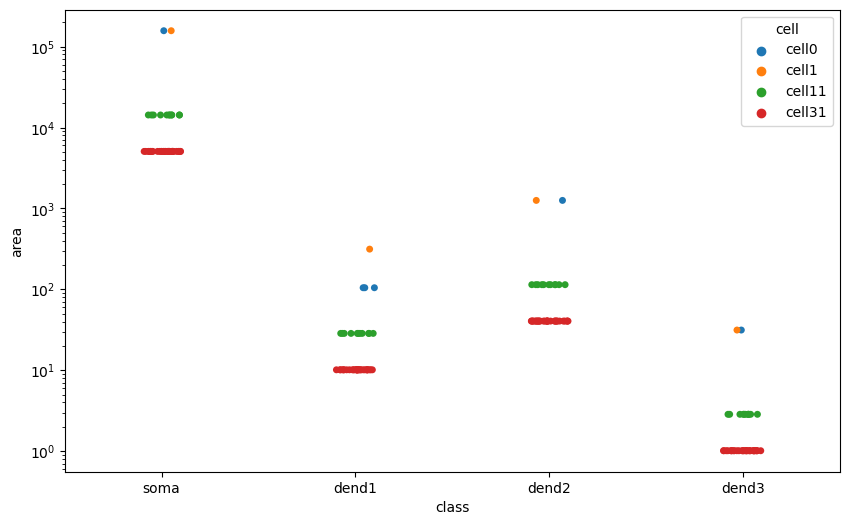

In [10]:
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize = (10,6))
sns.stripplot(imp_df,x='class',y='area',hue='cell',size=5)
ax.set_yscale('log')

<AxesSubplot:xlabel='class', ylabel='imp'>

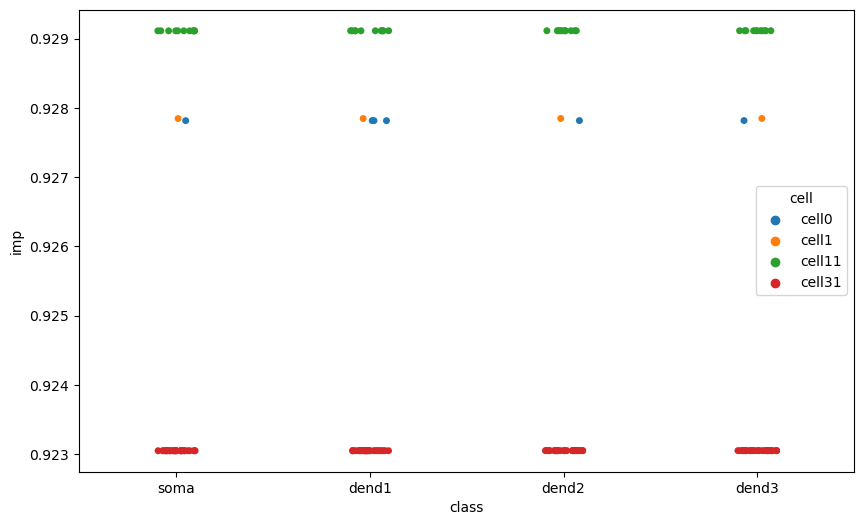

In [11]:
fig,ax = plt.subplots(1,1,figsize = (10,6))
sns.stripplot(imp_df,x='class',y='imp',hue='cell',size=5)

<AxesSubplot:xlabel='class', ylabel='normimp'>

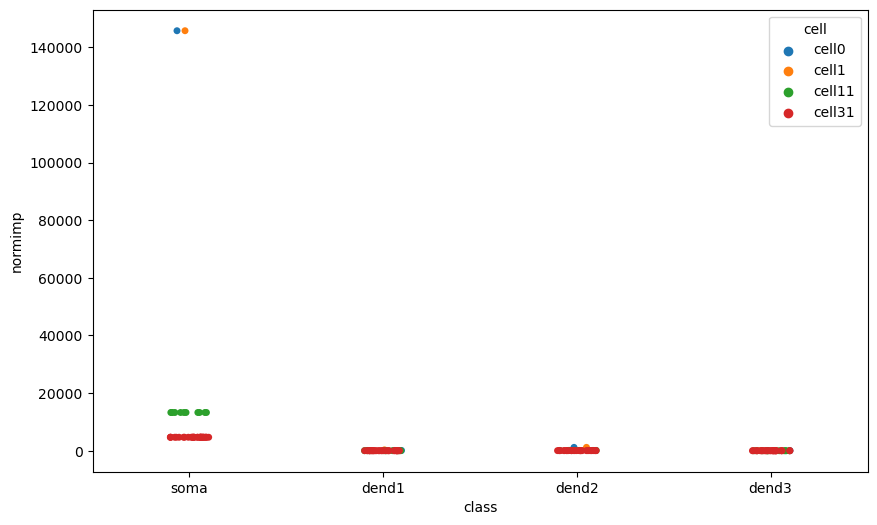

In [12]:
fig,ax = plt.subplots(1,1,figsize = (10,6))
sns.stripplot(imp_df,x='class',y='normimp',hue='cell',size=5)

In [13]:
table = pd.pivot_table(imp_df,values='imp',index='class',columns='cell',aggfunc=lambda x: np.sum(1/x)**(-1))
table

cell,cell0,cell1,cell11,cell31
class,,,,
dend1,0.309272,0.927847,0.084465,0.029776
dend2,0.927817,0.927848,0.084465,0.029776
dend3,0.927817,0.927848,0.084465,0.029776
soma,0.927816,0.927847,0.084465,0.029776


In [14]:
table = pd.pivot_table(imp_df,values='imp',index='class',columns='cell',aggfunc=[np.mean,np.median])
table

mean                                  median                      \
cell      cell0     cell1    cell11    cell31     cell0     cell1    cell11   
class                                                                         
dend1  0.927816  0.927847  0.929114  0.923050  0.927816  0.927847  0.929114   
dend2  0.927817  0.927848  0.929115  0.923050  0.927817  0.927848  0.929115   
dend3  0.927817  0.927848  0.929115  0.923051  0.927817  0.927848  0.929115   
soma   0.927816  0.927847  0.929113  0.923049  0.927816  0.927847  0.929113   

                 
cell     cell31  
class            
dend1  0.923050  
dend2  0.923050  
dend3  0.923051  
soma   0.923049

In [15]:
cell0.soma.area()

AttributeError: 'nrn.Section' object has no attribute 'area'